In [ ]:
# PERFORMANCE MAY VARY DEPENDING ON PC SPEC
# 
# TESTED PC SPECIFICATION
# OS: Windows 11 Pro 64 bit
# CPU: Intel(R) Core(TM) i7-10750H CPU @ 2.60 GHz (12 CPUs), ~2.6 GHz
# Average frequency: 3.00 GHz (Boost mode)
# RAM: 40GB
# GPU: NCIDIA GeFore RTX 3060 Laptop GPU
#
# I have recorded the run time for each block in the very beginning of 
# the block. So, feel free to reference...

In [ ]:
# RUN TIME: 1.5s

# imports
# we need to import os since we'll have to navigate directories.
import os

# we also need numpy for manipulating mathematical operations
import numpy as np

# this is for converting training image to gray scale
from PIL import Image

# this is for saving & loading trained model
import h5py

# during training, we need to shuffle samples; we're using random
import random

# we also need to process images (like converting to grayscale, resize, etc.)
# hence, let's import Image from PIL
from PIL import Image

# this is for debugging & displaying result
import matplotlib.pyplot as plt

In [ ]:
# RUN TIME: 1m 05s

# this class will load images for training
# directory is where the images are.
def load_dataset(directory):
# we'll gonna convert image_size to 28 x 28
# to make image consistent
    image_size=(28, 28)

    # array that contains flattened and normalized images
    flattened_images = [] 

    # array that contain the list of type of number
    # for example, the value would be 0,1,2,...8,9
    # since this model will predict a given number image.
    number_types = []

    # iterate from 0 to 9
    for subfolder_name in range(10):
        # we'll gonna define folder path
        # this line will define folder value to
        # train_images/0 for example
        folder = os.path.join(directory, str(subfolder_name))
        
        # for none provided folder
        # for example, when we're training images in 0 to 9
        # but we don't have folder 9, we'll gonna skip it
        if not os.path.isdir(folder):
            continue

        # at this point it's guarenteed that the folder path is valid
        # now, we'll process those images
        for filename in os.listdir(folder):
            # we will need to grab images in that folder
            # let's define the path of that image first
            filepath = os.path.join(folder, filename)
            # after this, we'll have filepath like
            # train_images/3/img123.jpg

            try:
                # open image
                selected_img = Image.open(filepath)

                # convert to gray scale
                selected_img = selected_img.convert('L')

                # convert the size of image to 28 x 28
                # this will either scale up or down the image
                # meaning there would be some pixels colored gray
                selected_img = selected_img.resize(image_size)

                # so, we'll store those cells of image into array first with float type
                cell_array = np.array(selected_img, dtype=np.float32)

                # let's first flatten the images in cell_array
                # this way, we'll have 32 x 32 = 1024
                # meaning for input layer, we'll have 1024 nodes.
                cell_array = cell_array.flatten()

                # since the pixel value of each cells vary between 0 to 255
                # we'll gonna normalize those to between 0 to 1 by deviding 255.0
                # this way, each pixel would be decimal number between 0 to 1
                # closer to 0 represents black
                # closer to 1 represents white
                cell_array = cell_array / 255.0

                # we'll gonna put those call array 
                # that has 0.284, 0.555... numbers for example
                # into the flattened_images
                flattened_images.append(cell_array)

                # also put the corrosponding filename into number types
                # for example, if current folder is 9 and we processed one of the images that represents 9
                # we'll make sure that this data is for 9 by putting filename into number_types
                number_types.append(subfolder_name)

            except Exception as ex:
                # if anything goes wrong
                # print error
                print(f"Error: Failed to load {filepath}: {ex}")

    flattened_images = np.array(flattened_images)
    number_types = np.array(number_types)
    return flattened_images, number_types
    
# this folder contains a list of subfolders named 0,1,2,3,...8,9
# which then each subfolders contain corrosponding hand written number images
directory = "../train_images"

flattened_result, type_result = load_dataset(directory)
print("Result")
print(f"\tNumber of images: {flattened_result.shape[0]}")
print(f"\tNumber of input layer: {flattened_result.shape[1]}")
print("Evaluated Numbers:")
print(f"{type_result}")

Result
	Number of images: 42000
	Number of input layer: 784
Evaluated Numbers:
[0 0 0 ... 9 9 9]


In [ ]:
# RUN TIME: 30m 57s

# now, let's train model based on those results.
# 1. input layer is 784 since we've defined like that
# 2. 4 hidden layers will have 512, 256, 128, 64
# 3. output layer is 10 for number between 0 to 9
# so, it's going to be like:
#   784 -> 512 -> 256 -> 128 -> 64 -> 10
class NeuralNetwork:
    # initiallizing constructor
    # input_layer: the size of image. in our case, 28 x 28
    # hidden1, hidden2, hidden3, hidden4: number of neurons in each hidden layers
    # output_size: since we're predicting number between 0 to 9, it's gonna be 10
    def __init__(self, input_layer, hidden1, hidden2, hidden3, hidden4, output_layer):
        # let's start by defining weights and biases.
        
        ### WEIGHT ###
        # using He initialization for ReLU
        # let's talk about 
        # self.weight1 = np.random.randn(input_layer, hidden1) * np.sqrt(2.0 / input_layer)
        #
        # first, np.random.randn(input_layer, hidden1) means:
        # since input_layer = 784, hidden1 = 512
        # this means:
        # create grid that's 784 x 512, assign random value between normal distribution of N(0, 1)
        # 
        # N(0, 1)
        # 0 means average
        # 1 variance
        # so, f(x) = (1 / (σ * sqrt(2 * π))) * exp(-(x - 𝜇)^2 / 2 * σ^2)
        # since np.random.randn(input_layer, hidden1) uses N(0, 1)
        # 𝜇 = 0 (the mean)
        # σ^2 = 1 (variance), σ = 1
        # hence, in our case, 𝜇 = 0 and σ = 1
        # the formula would be:
        # f(x) = (1 / (1 * sqrt(2 * π))) * exp(-(x^2) / (2 * 1))
        # => f(x) = (1 / sqrt(2 * π)) * exp(-(x^2) / 2)
        #
        # maximum of this curve occurs at 0 (mean) so, x = 𝜇 = 0
        # f(x) = (1 / sqrt(2 * π)) * exp(0) (exp(0) is 1, so, we're performing * 1)
        # => (1 / sqrt(2 * π)) * 1
        # => 0.3989...
        # meaning, for most of the time, the selected random value for cells will be placed at 0 for the most time
        # then less likely to be placed around +1, -1 
        # more less likely to be placed around +2, -2
        # very super dooper rarly placed in x > 5 , x < -5
        # this means the max and min where the the random values are placed is undefined.
        #
        # now, let's talk about np.sqrt(2.0 / input_layer)
        # so, this is called Kaiming He
        # we multiply this to rescale the weight values
        # keeping it consistent so that by the time we use those in next layer
        # it wouldn't either explode or vanish.
        # suppose we have 2 on avg, and each of the time, next layer multiplies itself.
        # when it comes to 10 layers, it's 1.34e+154 which is very huge number
        #
        # also, suppose every weight is about 0.1 instead
        # 1 -> 0.1 -> 0.01 -> ... 10^-10 
        # basically 0
        #
        # to avoid this, we multiply by np.sqrt(2.0 / input_layer)
        # why do we use input_layer?
        # it's cause according to Kaiming He rule, it says to set the weight variance to 2/fan-in
        # fan-in means number of inputs; in our case 784

        # biases are initialized to 0
        # they serve as trainable offsets added to each neuron’s weighted sum:
        #   z = W·x + b 
        # even though b starts at zero, gradient descent will adjust these offsets
        # independently of the weights to help each neuron fire at the right threshold
        # we'll come back to this later.


        # weight and bias from input layer to first hidden layer
        self.weight1 = np.random.randn(input_layer, hidden1) * np.sqrt(2.0 / input_layer)
        self.bias1 = np.zeros(hidden1)

        # weight and bias from first hidden layer to second hidden layer
        self.weight2 = np.random.randn(hidden1, hidden2) * np.sqrt(2.0 / hidden1)
        self.bias2 = np.zeros(hidden2)

        # weight and bias from second hidden layer to third hidden layer
        self.weight3 = np.random.randn(hidden2, hidden3) * np.sqrt(2.0 / hidden2)
        self.bias3 = np.zeros(hidden3)

        # weight and bias from third hidden layer to fourth hidden layer
        self.weight4 = np.random.randn(hidden3, hidden4) * np.sqrt(2.0 / hidden3)
        self.bias4 = np.zeros(hidden4)

        # weight and bias from fourth hidden layer to output layer
        self.weight5 = np.random.randn(hidden4, output_layer) * np.sqrt(2.0 / hidden4)
        self.bias5 = np.zeros(output_layer)

    def forward_propagation(self, input_layer):
        # forward propagation

        # Input Layer -> Hidden Layer 1 
        # Applied logics: Linear, Kaiming, ReLU
        # flattened_image.shape = (batch_size, input_size)
        # self.weight1.shape   = (input_size,  hidden1_size)
        # self.bias1.shape     = (hidden1_size,)
        self.hidden1_pre = input_layer.dot(self.weight1) + self.bias1  
        # -> shape (batch_size, hidden1_size)
        self.hidden1_act = np.maximum(0, self.hidden1_pre) # ReLU: f(x) = max(0,x)
        # if training:
        #     p1 = 0.4
        #     # mask of 0/1 then scale by 1/(1-p1)
        #     self.mask1 = (np.random.rand(*self.hidden1_act.shape) > p1) / (1 - p1)
        #     self.hidden1_act *= self.mask1

        # Hidden Layer 1 -> Hidden Layer 2
        # Applied logics: Linear, Kaiming, ReLU
        # self.hidden1_act.shape = (batch_size, hidden1_size)
        # self.weight2.shape     = (hidden1_size, hidden2_size)
        # self.bias2.shape       = (hidden2_size,)
        self.hidden2_pre = self.hidden1_act.dot(self.weight2) + self.bias2  
        # -> shape (batch_size, hidden2_size)
        self.hidden2_act = np.maximum(0, self.hidden2_pre) # ReLU: f(x) = max(0,x)
        # if training:
        #     p2 = 0.4
        #     self.mask2 = (np.random.rand(*self.hidden2_act.shape) > p2) / (1 - p2)
        #     self.hidden2_act *= self.mask2

        # Hidden Layer 2 -> Hidden Layer 3
        # Applied logics: Linear, Kaiming, ReLU
        # self.hidden2_act.shape = (batch_size, hidden2_size)
        # self.weight3.shape     = (hidden2_size, hidden3_size)
        # self.bias3.shape       = (hidden3_size,)
        self.hidden3_pre = self.hidden2_act.dot(self.weight3) + self.bias3  
        # -> shape (batch_size, hidden3_size)
        self.hidden3_act = np.maximum(0, self.hidden3_pre) # ReLU: f(x) = max(0,x)
        # if training:
        #     p3 = 0.3
        #     self.mask3 = (np.random.rand(*self.hidden3_act.shape) > p3) / (1 - p3)
        #     self.hidden3_act *= self.mask3

        # Hidden Layer 3 -> Hidden Layer 4
        # Applied logics: Linear, Kaiming, ReLU
        # self.hidden3_act.shape = (batch_size, hidden3_size)
        # self.weight4.shape     = (hidden2_size, hidden4_size)
        # self.bias4.shape       = (hidden4_size,)
        self.hidden4_pre = self.hidden3_act.dot(self.weight4) + self.bias4
        # -> shape (batch_size, hidden4_size)
        self.hidden4_act = np.maximum(0, self.hidden4_pre) # ReLU: f(x) = max(0,x)
        # if training:
        #     p4 = 0.2
        #     self.mask4 = (np.random.rand(*self.hidden4_act.shape) > p4) / (1 - p4)
        #     self.hidden4_act *= self.mask4
        
        # Hidden Layer 4 -> Output Layer
        # Applied logics: Linear, Softmax
        # first, multiply by weight matrix using dot production.
        # this way, we'll have unnormalized scores for 10 nodes (output layer) in other words, logits
        self.output_layer = self.hidden4_act.dot(self.weight5) + self.bias5

        # now that we have logits, for each logits, we'll find the maximum logit in each node in output layer
        # the reason we subtract that by np.max(self.output_layer, axis=1, keepdims=True)
        # is to stabilize values to avoid overflow

        shift = self.output_layer - np.max(self.output_layer, axis=1, keepdims=True)

        # then, using exponential function, it will make all scores strictly positive
        # since e^x always results positive number for any real number x
        exp_scores = np.exp(shift)

        # lastly, perform softmax
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return self.probs

    def compute_loss(self, inputs, labels):
        # from inputs, we're going to pull the number of samples first
        # in our case, since train_images contain 48000 images for training
        # num_examples would be 48000
        num_examples = inputs.shape[0]

        # we'll now perform forward propagation
        # after this, the probs value will have a shape (48000, 10)
        # 48000 training images
        # 10 represents resulting digits (0 - 9)
        probs = self.forward_propagation(inputs)

        # let's break down.
        # for probs[range(num_examples), labels]
        # it would look something like: probs[0, y0], probs[1, y1], ...
        # which basically means for probs[0, y0] example,
        # probability of the model gave to the true class of image 0
        # essentially, y0, y1, ... is a number between 0 - 9
        # 0, 1, ... is a probability in decimal places
        # so, let's say y0 is 2
        # and probs[0,2] = 0.7
        # this means it has 70% probability of 2

        # the problem is:
        # probs[range(num_examples), labels] returns a list of true classes like:
        # probs[0,1] = 0.9, probs[1,3] = 0.35...
        # there could be a probability of returning probs [0, 5] returning 0
        # simply means "we do have a true class that predicts number 5 but the probability is still 0"
        # which would make log(0) to -∞ breaking the calculation
        # so, we add tiny value 1e-8 which doesn't really effect when we train the model.
        none_zero_probs = probs[range(num_examples), labels] + 1e-8
        
        # so, the value in each list is 1e-8 <= x <= 1+1e-8
        # there could be possibility that log(x) where 1e-8 <= x <= 1+1e-8 returns positive value
        # but it's literally 0 chances of being 0
        # since log(probs[range(num_examples), labels] + 1e-8) returns negative value
        # we're gonna multiply those list of negative values by -1 to make it positive
        positive_log = -1 * np.log(none_zero_probs)

        # so, now positive_log contains a list of values, such as 0.8, 0.55, 0.97, etc
        # the lower the number, it means "oh, that's probability is expected for the selected number"
        # the higher the number, it means "wait... something is wrong here. that's interesting"
        
        # now, we're gonna determine data loss by adding all numbers in list then devide it by number of samples
        # this way, the data loss will contain single decimal values (0 < x <= 1)
        # for example, 
        # data_loss: 0.012 means the overall evaluated value is confident
        # data_loss: 0.789 means the overall evaluated value is not confident
        data_loss = np.sum(positive_log) / num_examples

        return data_loss

    # so, back_propagation is where we tune weight1, weight2, weight3, weight4, bias1, bias2, bias3, bias4
    # that's initialized in __init__
    # everytime we call this, those values in variables will change
    def back_propagation(self, inputs, labels, learning_rate):
        # at this point, forward_propagation() function should be called
        # in this example
        # inputs.shape = (48000, 784)
        #   - 48000 is the batch size (number of image samples)
        #   - 784 is the number of neurons in imput layer
        # labels.shape = (48000,)
        #   - 1 dimension array of 48000 length
        #   - each entry is an integer in 0,1,2,...,8.9 representing true class
        # learning_rate = 0.01
        #   - this is used for how big step the ai will take to update the weights and biases for each layer
        #   - if this is too large, it will jump and past the loss minimum,
        #       meaning it will ignore the data_loss we've calculated during the forward propagation
        #   - if this is too small, it means for each epoch, ai is learning little things,
        #       meaning we will need more epoches for higher accuracy, which slows down the training.

        # back propagation into output layer
        # let's start by grabbing the number of samples
        # we'll select the first one since it's guarenteed to be occupied
        # we need the number of samples because ai needs to know how many examples it will be processing
        # in details, it will be used for:
        #   - indexing gradient (remember we've converted the image to gray scale)
        #   - calculate the average of the gradient
        num_of_samples = inputs.shape[0]

        # let's now back propagate
        
        # starting from Output Layer
        # we'll copy probs which is 48000 rows and 10 columns
        # each cell contain value where 0 < probs[i,j] < 1
        # variable i belongs to class j (digit 0–9)
        # a value close to 0 means the model is very unsure it’s class j;
        # a value close to 1 means it’s highly confident.

        # error hear isn't refering to how often the model is wrong
        # it means gradient signal that tells you how much to nudge each logit
        output_error = self.probs.copy()

        # for each of one in the 48000 samples (rows):
        #  - use np.arange(num_of_samples) to pick one row index i
        #  - use labels[i] to pick the true‐class column for that row (in our case 0 to 9)
        #  - subtract 1 from output_error[i, labels[i]]
        # this turns p[i, k] into p[i, k] – 1 for the true class k, leaving other classes unchanged
        # since we're choosing specific classes that's in the list of numbers in labels
        output_error[np.arange(num_of_samples), labels] -= 1

        # so, after the line above
        #   - all non-true-class entries remain 0 < x < 1
        #   - each true-class entry becomes -1 < x < 0
        # like:
        # labels rows:
        # 0: 48000 entries (probs)
        # 1: 48000 entries (probs)
        # ...
        # 8: 48000 entries (probs)
        # 9: 48000 entries (probs)
        # and each labels will have one true-class-entry that's negative value

        # now, we devide those by number of samples for scaling
        # scaling those will make those value batch-size-independent during the evaluation
        # regardless of how many samples we process at once.
        output_error /= num_of_samples

        # now, calculate gradients for weight 5 and bias 5
        # remember, we're moving backwards

        # hidden4_act has 48000 rows that represents sample
        # 64 columns that represents neuron
        # we do dot production here
        # following is the example of calculation
        # suppose hidden4_act is: 
        # 1 2 3
        # 4 5 6
        # 
        # then we transpose hidden4_act:
        # 1 4
        # 2 5
        # 3 6
        # and output_error is:
        # 7 8
        # 9 10
        #
        # then for each row in transposed hidden4_act, you multiply with each column in output_error
        # first row:
        # 1 * 7 + 4 * 9 = 43
        # 1 * 8 + 5 * 10 = 48
        # result: [43 48]
        #
        # second row:
        # 2 * 7 + 5 * 9 = 59
        # 2 * 8 + 5 * 10 = 66
        # result: [59 66]
        #
        # third row:
        # 3 * 7 + 6 * 9 = 75
        # 3 * 8 + 6 * 10 = 84
        # result: [75 84]
        #
        # then, the result would be
        # [43 48]
        # [59 66]
        # [75 84]
        gradient_weight_5 = self.hidden4_act.T.dot(output_error)
        # print(gradient_weight_5)
        # print("\n")

        # now let's calculate the bias gradient for the output layer.
        # output_error has shape (48000, 10):
        #   – 48000 rows (one per sample)
        #   – 10 columns (one per output neuron, digits 0–9)
        # summing over axis=0 collapses the rows and yields a 1‑D array of length 10:
        #   gradient_bias_4[k] = sum_i output_error[i, k]
        # each column k accumulates the errors (some negative at true‑class positions)
        # for neuron k across all 48000 samples.
        # after the calculation, gradient_bias_4 is 1d array with length of 10
        # where each of 10 entries correspond to all output neurons
        gradient_bias_5 = np.sum(output_error, axis=0)
        # print(gradient_bias_5)

        # back propagation into hidden layer 4
        # so, after we do forward propagation, we have weight5 that's (64, 10)
        # and output_error is (48000, 10)
        # meaning we can transpose weight5 then dot product output_error
        # after dot production, gradient_loss_weight_4 will have a shape of (48000, 64)
        gradient_loss_weight_4 = output_error.dot(self.weight5.T)
        # gradient_loss_weight_4 *= self.mask4

        # hidden4_pre holds each neuron’s raw (pre‑ReLU) activation, which can be negative or positive
        # after ReLU, any hidden4_pre[i,j] <= 0 became hidden4_act[i,j] = 0 (neuron “off”)
        # in other words, hidden4_pre[i,j] <= 0 means "it's not an answer. we learn nothing from this neuron"
        # that's why in gradient_loss_weight_4, we mask those to 0
        # meaning "we're turning off the neuron for that value in gradient_loss_weight_4 since it's useless"
        # consequently, gradient_loss_weight_4 can be either positive, negative, or 0 (for deactivated neuron)
        gradient_loss_weight_4[self.hidden4_pre <= 0] = 0

        # after forward propagation, hidden3_act has a shape of (48000, 128)
        # meaning, we can transpose hidden3_act and dot product with gradient_loss_weight_4
        # why do we dot product with hidden3_act?
        # hidden3_act contains activation value of neurons for hidden layer 3
        # meaning "I'm this % sure that it's the right answer"
        # by dot producting hidden3_act by gradient_loss_weight_4,
        # it will return 2d array, saying "this gradient has this value of activation"
        # gradient_weight_4 can be: 
        #   - positive: the weight should be decreased since it contributes too much to loss
        #   - negative: the weight should be increased since it would lower the loss
        #   - zero: learn nothing 
        # so, we're kind of balancing(?) the weight for consistency
        gradient_weight_4 = self.hidden3_act.T.dot(gradient_loss_weight_4)

        # the thing is, for each gradient, there's still a weight that's important
        # we've recently calculated gradient_loss_weight_4 that's (48000, 64)
        # which contains the value of importance
        # so, we sum all the values in rows (48000 values) for each column
        # which will result 1d array with length of 64 that contains the importance rate
        # for each column in gradient_weight_4
        #
        # Q. if we're talking about importance rate, shouldn't it be an average instead of sum?
        # A. the values in gradient_loss_weight_3 are per-sample
        # we've recently scale those in here:
        # output_error /= num_of_samples
        # so, adding all those values results average importance per columns
        gradient_bias_4 = np.sum(gradient_loss_weight_4, axis=0)

        # concepts above applies same to the onces below
        # back propagation into hidden layer 3
        gradient_loss_weight_3 = gradient_loss_weight_4.dot(self.weight4.T)
        gradient_loss_weight_3[self.hidden3_pre <= 0] = 0
        # gradient_loss_weight_3 *= self.mask3
        gradient_weight_3 = self.hidden2_act.T.dot(gradient_loss_weight_3)
        gradient_bias_3 = np.sum(gradient_loss_weight_3, axis=0)

        # back propagation into hidden layer 2
        gradient_loss_weight_2 = gradient_loss_weight_3.dot(self.weight3.T)
        gradient_loss_weight_2[self.hidden2_pre <= 0] = 0
        # gradient_loss_weight_2 *= self.mask2
        gradient_weight_2 = self.hidden1_act.T.dot(gradient_loss_weight_2)
        gradient_bias_2 = np.sum(gradient_loss_weight_2, axis=0)

        # back propagation into hidden layer 1
        gradient_loss_weight_1 = gradient_loss_weight_2.dot(self.weight2.T)
        gradient_loss_weight_1[self.hidden1_pre <= 0] = 0
        # gradient_loss_weight_1 *= self.mask1
        gradient_weight_1 = inputs.T.dot(gradient_loss_weight_1)
        gradient_bias_1 = np.sum(gradient_loss_weight_1, axis=0)

        # we don't need gradient weight and bias for input layer
        # since it's just raw data where original image is parsed into 2d array

        # ok. so, we have:
        #   - 5 gradient_weights
        #   - 5 gradient_biases 
        # for each hidden layer and output layer
        #
        # so, weights are all random values
        # we've definded these in __init__ using Kaiming
        # np.random.randn(number of neurons in previous layer, number of neurons in current layer) 
        # * np.sqrt(2.0 / previous layer) 
        # and they're currently just random values that's meaningless
        # biases are all 0 with number of neurons in current layer
        # 
        # we need to tune all of both using gradient weights and gradient biases
        # to make it usable
        # Q. What's learning rate, and why do we use it?
        # A. learning rate is a scalar
        #    by multiplying with gradient_weights (that's 2d),
        #    it means "from each of the values in gradient weights, we're learning 0.01 (for example)"
        #    higher learning rate means: in each step, we're learning alot from that value meaning probability after
        #    each learning increases alot since we're stepping far, which may cause overfitting
        #    hence, instability
        #
        #    lower learning rate means: in each step we're learning little from that value meaning probability after
        #    each learning increases little since we're stepping short, which may result lower accuracy
        #    hence, slow convergence

        # Q. Why do we subtract learning_rate * gradient_weight?
        # A. so, from learning_rate * gradient_weight, we get either positive, negative, or zero
        #   - zero: basically means learning nothing from that gradient weight.
        #           in other words, it's already an optimal weight
        #   - positive: means this neuron has not accurate result, which means
        #               raising weight by this gradient_weight raises the loss
        #               so, we subtract it
        #   - negative: means this neuron has accurate result, which means
        #               raising weight by this negative gradient_weight lowers the loss
        #               so, we add it 
        #               (simple arithmatic -1 * -x is +x)
        # in conclusion, what's happenning here is we're trying to minimize the loss for accurate result
        # and we do those for all layers except for input layer
        self.weight5 -= learning_rate * gradient_weight_5
        self.bias5   -= learning_rate * gradient_bias_5
        self.weight4 -= learning_rate * gradient_weight_4
        self.bias4   -= learning_rate * gradient_bias_4
        self.weight3 -= learning_rate * gradient_weight_3
        self.bias3   -= learning_rate * gradient_bias_3
        self.weight2 -= learning_rate * gradient_weight_2
        self.bias2   -= learning_rate * gradient_bias_2
        self.weight1 -= learning_rate * gradient_weight_1
        self.bias1   -= learning_rate * gradient_bias_1

    def predict(self, input_layer):
        # so, we're gonna forward propagate input_layer
        # in this case, the shape of input_layer is (48000, 784)
        probs = self.forward_propagation(input_layer)

        # after forward propagation, probs variable will have a shape of (48000, 10) 
        # that represents the output layer

        # probs.shape == (48000, 10)
        # np.argmax(probs, axis=1) is basically doing:
        #   “For each ROW (each of the 48000 samples),
        #    scan across its 10 COLUMNS (class probabilities 0–9),
        #    and return the COLUMN INDEX where that row’s value is highest.”
        # the result is a length‑48000 array of integers in 0…9,
        # one predicted class per sample.
        #
        # here's the example with 3 samples and 4 classes:
        #   probs = [
        #     [0.1, 0.5, 0.2, 0.2],  # max at column 1 → predict class 1
        #     [0.3, 0.2, 0.4, 0.1],  # max at column 2 → predict class 2
        #     [0.0, 0.1, 0.1, 0.8]   # max at column 3 → predict class 3
        #   ]
        #   np.argmax(probs, axis=1)  →  [1, 2, 3]
        return np.argmax(probs, axis=1)


    # now, let's talk about training
    # flattened_result: this is what we got from loading 48000 images in previous code
    #                   the shape is basically (48000, 784) because we converted each of the
    #                   images to 28 x 28 which is 784 and we've done that for all 48000 images
    # number_types: the shape of this is 1d array with 48000 values where value lays between 0 to 9
    #               remember that each images were in the subfolder between 0 to 9? yeah, we grabbed
    #               those folder names then put it into number_types
    #               so, since we've iterated from subfolder 0 to 9
    #               flattened_result[0,] which is image for 0 points number_types[0]
    # epochs: so, this is the number of time we're performing learning using previous result
    #         so, if epochs is 10, then:
    #         - epochs 1: take those flattened_result then train model which then changes weights and biases
    #         - epochs 2: take weights and biases that's tuned from epoch 1, then tune neurons again
    #           ...
    #         - epochs 10: take weights and biases that's tuned from epoch 9, then tune neurons again
    # batch_size: number of images we grab once for each training
    #             so, let's say we have 100 images for training with 9 batch size
    #             during each epoch, out of 100 images, it's going to take 9 images for training
    #             in case we have left over, it's just going to take that (in above case, 1 image)
    #             - small batch_size: we're taking few images. Hence, each epoch will take longer
    #             - large batch_size: we're taking more images once. Hence, it causes sharper minima
    #                                 that may overfit the training data (lower test accuracy)
    # learning_rate: that's a scale value indicating for each step, how steep we're learning
    def train(self, flattened_result, number_types, epochs, batch_size, learning_rate):
        # in our example, flattened_result has a shape of (48000, 784)
        # so, we'll need to grab the number of images
        num_of_total_images = flattened_result.shape[0]

        # here, we loop number of epochs time to train and tune model
        for epoch in range(epochs):
            # now, we mix the number between 0 to 47999 (since we called np.random.permutation(48000))
            # to mix the images
            # Q. Why do we mix the images?
            # A. if you leave data in its original order every epoch, following problems happen:
            #   let's say in each batch, we have a group of images with all 0, and 
            #   next group of images with all 1
            #   during the training, ai would think "make everything look like 0" for bunch of steps
            #   then suddenly thinks "make everything look like 1"
            #   this causes
            #       - unsettled update (oscillating updates) since it's chasing one class then another
            #       - model can't learn a balanced decision boundary between classes resulting slow convergence
            #       - it may overfit on each class in isolation rather than learning shared features (poor generalization)
            # so, we mix it helps the ai learn a balanced decision boundary across all classes
            # let's try it out
            # mixed_position_for_image = np.arange(num_of_total_images)
            # oh damn... we have horrible accuracy of 38.87%...
            
# ---------------------- LOG ----------------------
# Epoch 1: Loss = 5.7466, Training Accuracy = 9.97%
# Epoch 2: Loss = 5.0580, Training Accuracy = 9.99%
# Epoch 3: Loss = 4.8297, Training Accuracy = 11.32%
# Epoch 4: Loss = 4.7153, Training Accuracy = 15.74%
# Epoch 5: Loss = 4.6222, Training Accuracy = 20.29%
# Epoch 6: Loss = 4.5165, Training Accuracy = 24.03%
# Epoch 7: Loss = 4.3883, Training Accuracy = 26.78%
# Epoch 8: Loss = 4.2436, Training Accuracy = 29.05%
# Epoch 9: Loss = 4.0943, Training Accuracy = 30.73%
# Epoch 10: Loss = 3.9381, Training Accuracy = 32.40%
# Epoch 11: Loss = 3.7837, Training Accuracy = 33.71%
# Epoch 12: Loss = 3.6368, Training Accuracy = 35.02%
# Epoch 13: Loss = 3.4876, Training Accuracy = 36.09%
# Epoch 14: Loss = 3.3400, Training Accuracy = 37.13%
# Epoch 15: Loss = 3.2073, Training Accuracy = 38.03%
# Epoch 16: Loss = 3.0905, Training Accuracy = 38.87%

            mixed_position_for_image = np.random.permutation(num_of_total_images)

            # now, we take those shuffled list then take according image that's in flattened_result
            # as a result, shuffled_flattened_images will have a shape of (48000, 784) where
            # 48000 images are mixed
            shuffled_flattened_images = flattened_result[mixed_position_for_image]

            # flattened images are shuffled using mixed_position_for_image
            # so, we take mixed_position_for_image and reposition number_types then store it into shuffled_number_types
            # this way, shuffled_number_types will be 1d array with 48000 length
            # where each value represents the result for each shuffled flattened image in shuffled_flattened_images
            shuffled_number_types = number_types[mixed_position_for_image]

            # let's evaluate those shuffled images
            # currently we have 48000 shuffled images
            # for each iteration, we take the number of images that's in batch_size
            for i in range(0, num_of_total_images, batch_size):
                shuffled_image_batch = shuffled_flattened_images[i:i+batch_size]
                shuffled_number_types_batch = shuffled_number_types[i:i+batch_size]
                # at this point, since we're grabbing 64 image out of 48000 in every iteration
                # the shape of shuffled_image_batch will be (64, 784)
                # and the shape of shuffled_number_types_batch will be (64)

                # then, we perform forward propagation for 64 images
                # as a result, we will have forward propagated self.probs
                # where the shape is (batch_size, 10) 
                # in our case, (64, 10)
                self.forward_propagation(shuffled_image_batch)

                # then we perform back propagation for those self.probs using shuffled number types and learning rate
                # as a result, we will have back propagated followings:
                # - weight4, weight3, weight2, weight1
                # - bias4, bias3, bias2, bias1
                # so, yeah. This is the part where we update those values;
                # essensially, taking previous ones then tune it over and over again in each epoch
                self.back_propagation(shuffled_image_batch, shuffled_number_types_batch, learning_rate)
            
            # now let's print evaluated result
            # note that compute_loss() isn't necessary
            # it's just to print details of loss after each epoch after evaluation
            # as explained above, higher loss means unconfident
            # lower loss means pretty confident

            # commenting out for better performance
            loss = self.compute_loss(flattened_result, number_types)

            # let's calculate the accuracy
            # after calling predict() with flattened_result
            # it will return 1d array with 48000 integers where the value of integer lays between 0 to 9
            
            # commenting out for better performance
            preds = self.predict(flattened_result)

            # then, we compare each of those with unshuffled number types
            # that looks something like: [0,0,0,...,1,1,...,2,2,2,...8,8,9,....9,9] since it's unshuffled with 48000 length
            # in predict() since we're performing forward propagation for flattened_result
            # it won't have exact row as number_types
            # so, we do calculate mean value for each row in flattened_result (2d) and number_types

            # preds: shape(48000,), predicted labels for each image in flattened_result
            # number_types: shape (48000,), true labels aligned to the same images
            # preds == number_types: boolean array of length 48000 (true means correct, false means wrong)
            # np.mean(): fraction of correct predictions (overall accuracy)
            
            # commenting out for better performance
            acc = np.mean(preds == number_types)

            # now that we have all those information, let's print the result for each epoch
            
            # print(f"Epoch {epoch+1}")
            # commenting out for better performance
            print(f"Epoch {epoch+1}: Loss = {loss:.7f}, Training Accuracy = {acc*100:.4f}%")


# training initialization
input_size = 28 * 28        # we recently resized image to 28 x 28 dimension. this also means input layer has 784 neurons
hidden1_size = 512          # number of neurons for first hidden layer
hidden2_size = 256          # number of neurons for second hidden layer
hidden3_size = 128          # number of neurons for third hidden layer
hidden4_size = 64           # number of neurons for fourth hidden layer
output_size = 10            # digits between 0 to 9. this also means output layer has 10 neurons
learning_rate = 0.005        # constant for learning rate (how much we're stepping back and forward)
epochs = 64                 # number of time we're performing train for the whole images (48000 images)
batch_size = 32             # number of images we're taking for each training

# initialize the neural network with number of neurons for each layer 
# (input layer, hidden layer 1, hidden layer 2, hidden layer 3, hidden layer 4, output layer)
trained_neural_instance = NeuralNetwork(input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, output_size)

# fire training
trained_neural_instance.train(flattened_result, type_result, epochs, batch_size, learning_rate)

NameError: name 'flattened_result' is not defined

In [ ]:
# LOG
# Epoch 1: Loss = 0.3259809, Training Accuracy = 90.4810%
# Epoch 2: Loss = 0.2407855, Training Accuracy = 92.9929%
# Epoch 3: Loss = 0.2059041, Training Accuracy = 93.8810%
# Epoch 4: Loss = 0.1754173, Training Accuracy = 94.8381%
# Epoch 5: Loss = 0.1494788, Training Accuracy = 95.7548%
# Epoch 6: Loss = 0.1278488, Training Accuracy = 96.3619%
# Epoch 7: Loss = 0.1119146, Training Accuracy = 96.7476%
# Epoch 8: Loss = 0.1151055, Training Accuracy = 96.5762%
# Epoch 9: Loss = 0.0920723, Training Accuracy = 97.3929%
# Epoch 10: Loss = 0.0899236, Training Accuracy = 97.3476%
# Epoch 11: Loss = 0.0739582, Training Accuracy = 97.9810%
# Epoch 12: Loss = 0.0722737, Training Accuracy = 98.0071%
# Epoch 13: Loss = 0.0776263, Training Accuracy = 97.7452%
# Epoch 14: Loss = 0.0565974, Training Accuracy = 98.5214%
# Epoch 15: Loss = 0.0535524, Training Accuracy = 98.5881%
# Epoch 16: Loss = 0.0553388, Training Accuracy = 98.4119%
# Epoch 17: Loss = 0.0438287, Training Accuracy = 98.8833%
# Epoch 18: Loss = 0.0539669, Training Accuracy = 98.3167%
# Epoch 19: Loss = 0.0377793, Training Accuracy = 99.0786%
# Epoch 20: Loss = 0.0337754, Training Accuracy = 99.2381%
# Epoch 21: Loss = 0.0302086, Training Accuracy = 99.2976%
# Epoch 22: Loss = 0.0283187, Training Accuracy = 99.4095%
# Epoch 23: Loss = 0.0265706, Training Accuracy = 99.4190%
# Epoch 24: Loss = 0.0222864, Training Accuracy = 99.6048%
# Epoch 25: Loss = 0.0262107, Training Accuracy = 99.3667%
# Epoch 26: Loss = 0.0200116, Training Accuracy = 99.6714%
# Epoch 27: Loss = 0.0213134, Training Accuracy = 99.5619%
# Epoch 28: Loss = 0.0171421, Training Accuracy = 99.7381%
# Epoch 29: Loss = 0.0147964, Training Accuracy = 99.8190%
# Epoch 30: Loss = 0.0144486, Training Accuracy = 99.7952%
# Epoch 31: Loss = 0.0144310, Training Accuracy = 99.7976%
# Epoch 32: Loss = 0.0123299, Training Accuracy = 99.8643%
# Epoch 33: Loss = 0.0102801, Training Accuracy = 99.9143%
# Epoch 34: Loss = 0.0095352, Training Accuracy = 99.9310%
# Epoch 35: Loss = 0.0087998, Training Accuracy = 99.9286%
# Epoch 36: Loss = 0.0083603, Training Accuracy = 99.9214%
# Epoch 37: Loss = 0.0073286, Training Accuracy = 99.9571%
# Epoch 38: Loss = 0.0069129, Training Accuracy = 99.9738%
# Epoch 39: Loss = 0.0063719, Training Accuracy = 99.9738%
# Epoch 40: Loss = 0.0060625, Training Accuracy = 99.9810%
# Epoch 41: Loss = 0.0056494, Training Accuracy = 99.9762%
# Epoch 42: Loss = 0.0063485, Training Accuracy = 99.9595%
# Epoch 43: Loss = 0.0052331, Training Accuracy = 99.9810%
# Epoch 44: Loss = 0.0045256, Training Accuracy = 99.9881%
# Epoch 45: Loss = 0.0045195, Training Accuracy = 99.9905%
# Epoch 46: Loss = 0.0040768, Training Accuracy = 99.9952%
# Epoch 47: Loss = 0.0045057, Training Accuracy = 99.9952%
# Epoch 48: Loss = 0.0038885, Training Accuracy = 99.9929%
# Epoch 49: Loss = 0.0033603, Training Accuracy = 99.9976%
# Epoch 50: Loss = 0.0033631, Training Accuracy = 99.9929%
# Epoch 51: Loss = 0.0032265, Training Accuracy = 99.9976%
# Epoch 52: Loss = 0.0029852, Training Accuracy = 99.9976%
# Epoch 53: Loss = 0.0027567, Training Accuracy = 99.9976%
# Epoch 54: Loss = 0.0027406, Training Accuracy = 99.9976%
# Epoch 55: Loss = 0.0027418, Training Accuracy = 99.9976%
# Epoch 56: Loss = 0.0024753, Training Accuracy = 99.9976%
# Epoch 57: Loss = 0.0024117, Training Accuracy = 99.9976%
# Epoch 58: Loss = 0.0022590, Training Accuracy = 100.0000%
# Epoch 59: Loss = 0.0021955, Training Accuracy = 99.9976%
# Epoch 60: Loss = 0.0022104, Training Accuracy = 99.9952%
# Epoch 61: Loss = 0.0020231, Training Accuracy = 100.0000%
# Epoch 62: Loss = 0.0019751, Training Accuracy = 100.0000%
# Epoch 63: Loss = 0.0019074, Training Accuracy = 100.0000%
# Epoch 64: Loss = 0.0018451, Training Accuracy = 100.0000%

In [ ]:
# RUN TIME: 0.0s

# we obviously don't want to train everytime we run the code
# so, let's save those trained neurons so that we can reuse it
# we're gonna export those as HDF5 file

# “w” mode: create file (or overwrite existing)
# each .create_dataset call writes a NumPy array to disk under a named key.
with h5py.File("trained_model.h5", "w") as hf:
    hf.create_dataset("weight1", data=trained_neural_instance.weight1)
    hf.create_dataset("bias1",   data=trained_neural_instance.bias1)
    hf.create_dataset("weight2", data=trained_neural_instance.weight2)
    hf.create_dataset("bias2",   data=trained_neural_instance.bias2)
    hf.create_dataset("weight3", data=trained_neural_instance.weight3)
    hf.create_dataset("bias3",   data=trained_neural_instance.bias3)
    hf.create_dataset("weight4", data=trained_neural_instance.weight4)
    hf.create_dataset("bias4",   data=trained_neural_instance.bias4)
    hf.create_dataset("weight5", data=trained_neural_instance.weight5)
    hf.create_dataset("bias5",   data=trained_neural_instance.bias5)


In [ ]:
########## CHECK POINT ##########

In [ ]:
# in case you're skipping training part
# start from this block
# PLEASE READ THE PREVIOUS CODE 
# for duplicated codes, i have ommitted the comments since
# it's explained above

In [ ]:
# initialize necessary libraries
import os
import numpy as np
from PIL import Image
import h5py
import random
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# RUN TIME: 0.0s

# in case we do have HDF5 file, but not the NerualNetowrk class
# let's redefine it
# this block is only necessary if you've got HDF5 model but would like to skip
# training scope
class NeuralNetwork:
    def __init__(self, input_layer, hidden1, hidden2, hidden3, hidden4, output_layer):
        self.weight1 = None
        self.bias1   = None
        self.weight2 = None
        self.bias2   = None
        self.weight3 = None
        self.bias3   = None
        self.weight4 = None
        self.bias4   = None
        self.weight5 = None
        self.bias5   = None
    
    def forward_propagation(self, input_layer):
        self.hidden1_pre = input_layer.dot(self.weight1) + self.bias1
        self.hidden1_act = np.maximum(0, self.hidden1_pre) 
        
        self.hidden2_pre = self.hidden1_act.dot(self.weight2) + self.bias2
        self.hidden2_act = np.maximum(0, self.hidden2_pre)
        
        self.hidden3_pre = self.hidden2_act.dot(self.weight3) + self.bias3
        self.hidden3_act = np.maximum(0, self.hidden3_pre)
        
        self.hidden4_pre = self.hidden3_act.dot(self.weight4) + self.bias4
        self.hidden4_act = np.maximum(0, self.hidden4_pre)

        self.output_layer = self.hidden4_act.dot(self.weight5) + self.bias5
        scaled_logits = self.output_layer

        shift = scaled_logits - np.max(scaled_logits, axis=1, keepdims=True)
        exp_scores = np.exp(shift)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return self.probs

    def compute_loss(self, inputs, labels):
        num_examples = inputs.shape[0]
        probs = self.forward_propagation(inputs)
        none_zero_probs = probs[range(num_examples), labels] + 1e-8
        positive_log = -1 * np.log(none_zero_probs)
        data_loss = np.sum(positive_log) / num_examples

        return data_loss

    def back_propagation(self, inputs, labels, learning_rate):
        num_of_samples = inputs.shape[0]

        output_error = self.probs.copy()
        output_error[np.arange(num_of_samples), labels] -= 1
        output_error /= num_of_samples

        gradient_weight_5 = self.hidden4_act.T.dot(output_error)
        gradient_bias_5 = np.sum(output_error, axis=0)
        
        gradient_loss_weight_4 = output_error.dot(self.weight5.T)
        gradient_loss_weight_4[self.hidden4_pre <= 0] = 0
        gradient_weight_4 = self.hidden3_act.T.dot(gradient_loss_weight_4)
        gradient_bias_4 = np.sum(gradient_loss_weight_4, axis=0)

        gradient_loss_weight_3 = gradient_loss_weight_4.dot(self.weight4.T)
        gradient_loss_weight_3[self.hidden3_pre <= 0] = 0
        gradient_weight_3 = self.hidden2_act.T.dot(gradient_loss_weight_3)
        gradient_bias_3 = np.sum(gradient_loss_weight_3, axis=0)
        
        gradient_loss_weight_2 = gradient_loss_weight_3.dot(self.weight3.T)
        gradient_loss_weight_2[self.hidden2_pre <= 0] = 0
        gradient_weight_2 = self.hidden1_act.T.dot(gradient_loss_weight_2)
        gradient_bias_2 = np.sum(gradient_loss_weight_2, axis=0)
        
        gradient_loss_weight_1 = gradient_loss_weight_2.dot(self.weight2.T)
        gradient_loss_weight_1[self.hidden1_pre <= 0] = 0
        gradient_weight_1 = inputs.T.dot(gradient_loss_weight_1)
        gradient_bias_1 = np.sum(gradient_loss_weight_1, axis=0)

        self.weight5 -= learning_rate * gradient_weight_5
        self.bias5   -= learning_rate * gradient_bias_5
        self.weight4 -= learning_rate * gradient_weight_4
        self.bias4   -= learning_rate * gradient_bias_4
        self.weight3 -= learning_rate * gradient_weight_3
        self.bias3   -= learning_rate * gradient_bias_3
        self.weight2 -= learning_rate * gradient_weight_2
        self.bias2   -= learning_rate * gradient_bias_2
        self.weight1 -= learning_rate * gradient_weight_1
        self.bias1   -= learning_rate * gradient_bias_1

    def predict(self, input_layer):
        probs = self.forward_propagation(input_layer)
        return np.argmax(probs, axis=1)
    
    def train(self, flattened_result, number_types, epochs, batch_size, learning_rate):
        num_of_total_images = flattened_result.shape[0]
        
        for epoch in range(epochs):
            mixed_position_for_image = np.random.permutation(num_of_total_images)
            shuffled_flattened_images = flattened_result[mixed_position_for_image]
            shuffled_number_types = number_types[mixed_position_for_image]

            for i in range(0, num_of_total_images, batch_size):
                shuffled_image_batch = shuffled_flattened_images[i:i+batch_size]
                shuffled_number_types_batch = shuffled_number_types[i:i+batch_size]
                self.forward_propagation(shuffled_image_batch)
                self.back_propagation(shuffled_image_batch, shuffled_number_types_batch, learning_rate)
            
            loss = self.compute_loss(flattened_result, number_types)
            preds = self.predict(flattened_result)
            acc = np.mean(preds == number_types)
            print(f"Epoch {epoch+1}: Loss = {loss:.7f}, Training Accuracy = {acc*100:.4f}%")

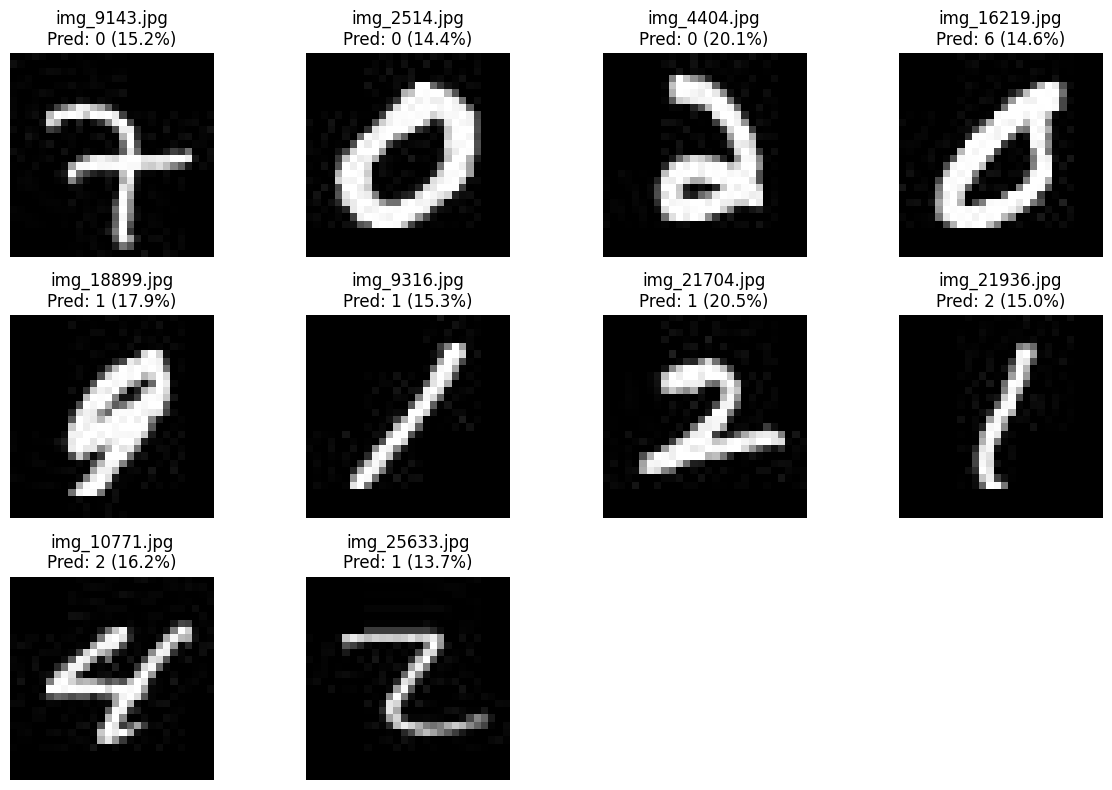

In [ ]:
# RUN TIME: 0.4s

# now, let's test the trained HDF5 model with 10 random images from test_images
# if you see an error message saying "you're misssing NeuralNetwork class" 
# just run the block above. You'll now have that class

# let's start by loading the trained parameters from HDF5
# first, for larification, let's redefine layers
input_size = 28 * 28
hidden1_size = 512
hidden2_size = 256
hidden3_size = 128
hidden4_size = 64
output_size = 10

# then we define a loaded_model with above properties
# since our HDF5 file contains weights and biases for each layer
# we will assign those into the loaded_model

# "r" means open for reading; each dataset returns an h5py.Dataset which we slice ([:]) into a NumPy array
with h5py.File("trained_model.h5", "r") as hf:
    # recreate the neural network with the same layer sizes
    loaded_model = NeuralNetwork(
        input_layer = 28*28,
        hidden1 = 512, hidden2 = 256, hidden3 = 128, hidden4 = 64,
        output_layer = 10
    )

    # overwrite its randomly‐initialized weights & biases 
    # with the saved ones:
    loaded_model.weight1 = hf["weight1"][:]
    loaded_model.bias1 = hf["bias1"][:]
    loaded_model.weight2 = hf["weight2"][:]
    loaded_model.bias2 = hf["bias2"][:]
    loaded_model.weight3 = hf["weight3"][:]
    loaded_model.bias3 = hf["bias3"][:]
    loaded_model.weight4 = hf["weight4"][:]
    loaded_model.bias4 = hf["bias4"][:]
    loaded_model.weight5 = hf["weight5"][:]
    loaded_model.bias5 = hf["bias5"][:]

# gather all images from test_images file
test_directory_name = "../test_images"
all_files = os.listdir(test_directory_name)

# grab 10 randomly out of them
selected_images = random.sample(all_files, 10)

# preprocess the images exactly how we did during training
parsed_image_list = []
flattened_images = []
for fname in selected_images:
    path = os.path.join(test_directory_name, fname)
    try:
        img = Image.open(path).convert("L").resize((28, 28))
        parsed_image_list.append(img)

        arr = np.asarray(img, dtype=np.float32).flatten() / 255.0
        flattened_images.append(arr)

    except Exception as e:
        print(f"ERROR loading {fname}: {e}")

# build a (10 × 784) array for prediction
flattened_test = np.stack(flattened_images)  # shape = (10, 784)

# run forward pass and pick the top class
# again, since it's going to select the largest value among others that 
# represents each digit where each index represents from 0 to 9
# the shape we get for processing one single image, we get 10 probabilities
# which then we have 10 of those.
# so, the shape is (10, 10)
probs = loaded_model.forward_propagation(flattened_test)

# and we grab the alrgest among those
predictions = np.argmax(probs, axis = 1)

# then, we convert the according value to percentage by multiplying it by 100
confidence = np.max(probs, axis = 1) * 100

# display result
# let's first set each cell size to 12 x 8 inches
plt.figure(figsize = (12, 8))

# then we display all 10 images
# parsed_image_list, predictions, confidence, and selected_images are each length‑10 sequences.
# using zip() will iterate them in parallel so that on each loop:
#   - img, pred, conf, fname = the i-th image, its predicted class, its confidence, and its filename
# enumerate() wraps that to assign i (0 to 9), which is used for placing each subplot in the grid
for i, (img, pred, conf, fname) in enumerate(zip(parsed_image_list, predictions, confidence, selected_images)):
    # since we have 10 images
    # let's define a grid with 3 rows 4 columns
    # then place each image in i-th position
    plt.subplot(3, 4, i + 1)

    # draw an image
    plt.imshow(img, cmap="gray")

    # write down evaluated results as title
    plt.title(f"{fname}\nPred: {pred} ({conf:.1f}%)")

    # let's turn off axis for nice-looking
    plt.axis("off")

# for nice-looking as well
plt.tight_layout()

# display the grid
plt.show()


In [24]:
# what you expect from above code is 10 random image 
# between 0 to 9 with the AI model predicting numbers 
# with over 95% confidency mostly

# let's test it out with our images
# my_images folder contains my hand written number images 
# for each 0 to 9 digits
# below code will use those to evaluate the model

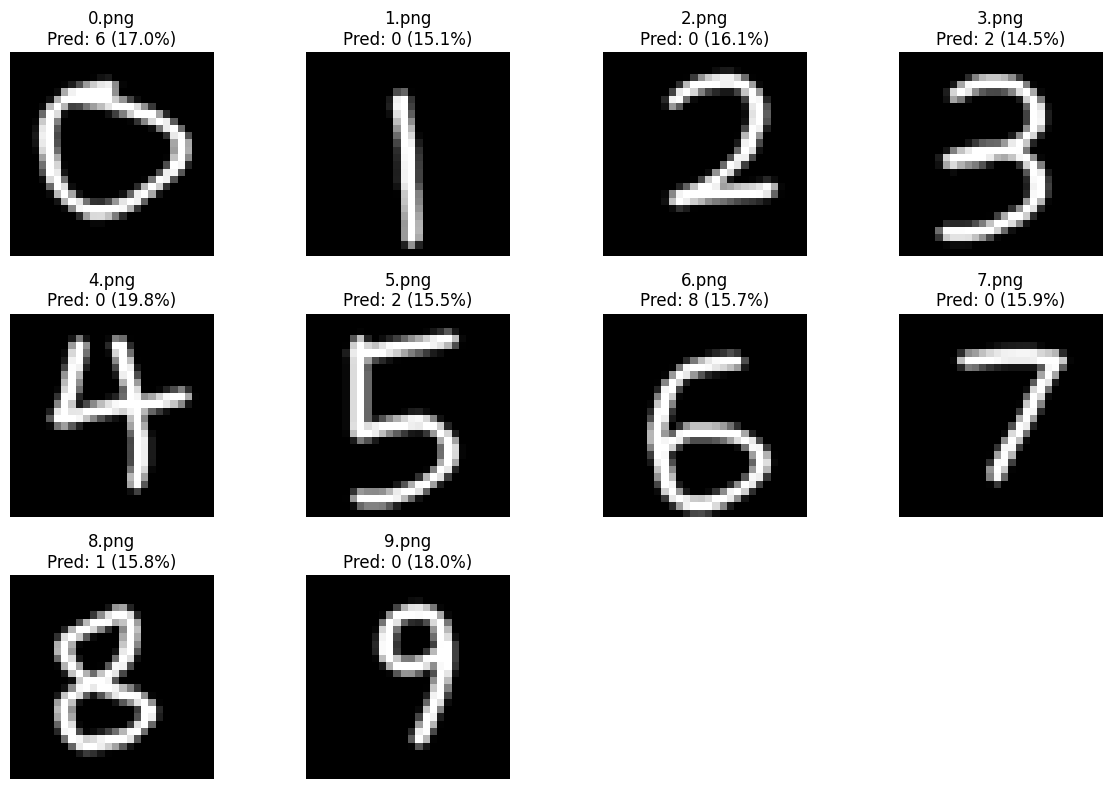

In [ ]:
# RUN TIME: 0.5s

# what we're doing here is basically the exact same thing
# except for:
#   - modified to test all 10 images instead of 10 random images
#   - added thickening image for better recognition
#   - added inverting image since the images are drawn black on white canvas

input_size = 28 * 28
hidden1_size = 512
hidden2_size = 256
hidden3_size = 128
hidden4_size = 64
output_size = 10

with h5py.File("trained_model.h5", "r") as hf:
    loaded_model = NeuralNetwork(
        input_layer = 28*28,
        hidden1 = 512, hidden2 = 256, hidden3 = 128, hidden4 = 64,
        output_layer = 10
    )

    loaded_model.weight1 = hf["weight1"][:]
    loaded_model.bias1 = hf["bias1"][:]
    loaded_model.weight2 = hf["weight2"][:]
    loaded_model.bias2 = hf["bias2"][:]
    loaded_model.weight3 = hf["weight3"][:]
    loaded_model.bias3 = hf["bias3"][:]
    loaded_model.weight4 = hf["weight4"][:]
    loaded_model.bias4 = hf["bias4"][:]
    loaded_model.weight5 = hf["weight5"][:]
    loaded_model.bias5 = hf["bias5"][:]

def thicken(arr, passes):
    for _ in range(passes):
        up    = np.zeros_like(arr); up[:-1, :] = arr[1:, :]
        down  = np.zeros_like(arr); down[1:, :] = arr[:-1, :]
        left  = np.zeros_like(arr); left[:, :-1] = arr[:, 1:]
        right = np.zeros_like(arr); right[:, 1:] = arr[:, :-1]
        arr = np.maximum.reduce([arr, up, down, left, right])
    return arr

test_directory_name = "../my_images"
all_files = os.listdir(test_directory_name)
selected_images = all_files
parsed_image_list = []
flattened_images = []

for fname in selected_images:
    path = os.path.join(test_directory_name, fname)
    try:
        img = Image.open(path)
        img = img.convert('L')

        # before we resize, let's invert the image
        arr = np.array(img, dtype=np.float32)
        arr = 255 - arr
        arr = thicken(arr, 11)
        
        img = Image.fromarray(arr.astype(np.uint8))
        img = img.resize((28, 28))
        parsed_image_list.append(img)

        arr = np.asarray(img, dtype=np.float32).flatten() / 255.0
        flattened_images.append(arr)

    except Exception as e:
        print(f"ERROR loading {fname}: {e}")

flattened_test = np.stack(flattened_images)
probs = loaded_model.forward_propagation(flattened_test)
predictions = np.argmax(probs, axis=1)
confidence  = np.max(probs, axis=1) * 100
plt.figure(figsize=(12, 8))

for i, (img, pred, conf, fname) in enumerate(zip(parsed_image_list, predictions, confidence, selected_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{fname}\nPred: {pred} ({conf:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# what we expect above is our AI predicting most of the digits accurately

# RESULT
# confidency is pretty high for most of the values
# however, we still see some low confidency
# let's retrain the model

In [ ]:
# RUN TIME: 25.3s
# in case you've started from testing out existing model
# you'll have to grab the images from train_images folder
# following code is exactly the same from previous code 
# where we grab the images from train_images

def load_dataset(directory):
    image_size=(28, 28)
    flattened_images = [] 
    number_types = []

    for subfolder_name in range(10):
        folder = os.path.join(directory, str(subfolder_name))\
        
        if not os.path.isdir(folder):
            continue

        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)

            try:
                selected_img = Image.open(filepath)
                selected_img = selected_img.convert('L')
                selected_img = selected_img.resize(image_size)
                cell_array = np.array(selected_img, dtype=np.float32)
                cell_array = cell_array.flatten()
                cell_array = cell_array / 255.0
                flattened_images.append(cell_array)
                number_types.append(subfolder_name)

            except Exception as ex:
                print(f"Error: Failed to load {filepath}: {ex}")

    flattened_images = np.array(flattened_images)
    number_types = np.array(number_types)
    return flattened_images, number_types
    
directory = "../train_images"

flattened_result, type_result = load_dataset(directory)
print("Result")
print(f"\tNumber of images: {flattened_result.shape[0]}")
print(f"\tNumber of input layer: {flattened_result.shape[1]}")
print("Evaluated Numbers:")
print(f"{type_result}")

Result
	Number of images: 42000
	Number of input layer: 784
Evaluated Numbers:
[0 0 0 ... 9 9 9]


In [ ]:
# RUN TIME: 3m 46s
import h5py

# reinitialize model
model = NeuralNetwork(flattened_result.shape[1], 512, 256, 128, 64, 10)

# load the existing weights/biases from trained_model.h5
# then assign those into model
with h5py.File('trained_model.h5', 'r') as hf:
    model.weight1 = hf['weight1'][:]
    model.bias1   = hf['bias1'][:]
    model.weight2 = hf['weight2'][:]
    model.bias2   = hf['bias2'][:]
    model.weight3 = hf['weight3'][:]
    model.bias3   = hf['bias3'][:]
    model.weight4 = hf['weight4'][:]
    model.bias4   = hf['bias4'][:]
    model.weight5 = hf['weight5'][:]
    model.bias5   = hf['bias5'][:]

print("Loaded existing model parameters from trained_model.h5")

# retrain with:
#   - 20 epoches
#   - 32 batch size
#   - 0.005 learning rate
model.train(
    flattened_result,
    type_result,
    epochs=20,
    batch_size=32,
    learning_rate=0.005
)


Loaded existing model parameters from trained_model.h5
Epoch 1: Loss = 0.0017805, Training Accuracy = 100.0000%
Epoch 2: Loss = 0.0017210, Training Accuracy = 100.0000%
Epoch 3: Loss = 0.0016420, Training Accuracy = 100.0000%
Epoch 4: Loss = 0.0016802, Training Accuracy = 100.0000%
Epoch 5: Loss = 0.0015989, Training Accuracy = 100.0000%
Epoch 6: Loss = 0.0015758, Training Accuracy = 100.0000%
Epoch 7: Loss = 0.0014738, Training Accuracy = 100.0000%
Epoch 8: Loss = 0.0014588, Training Accuracy = 100.0000%
Epoch 9: Loss = 0.0013923, Training Accuracy = 100.0000%
Epoch 10: Loss = 0.0013571, Training Accuracy = 100.0000%
Epoch 11: Loss = 0.0014312, Training Accuracy = 100.0000%
Epoch 12: Loss = 0.0012796, Training Accuracy = 100.0000%
Epoch 13: Loss = 0.0012726, Training Accuracy = 100.0000%
Epoch 14: Loss = 0.0012253, Training Accuracy = 100.0000%
Epoch 15: Loss = 0.0012016, Training Accuracy = 100.0000%
Epoch 16: Loss = 0.0011774, Training Accuracy = 100.0000%
Epoch 17: Loss = 0.0011489

In [ ]:
# LOG
# Loaded existing model parameters from trained_model.h5
# Epoch 1: Loss = 0.0017805, Training Accuracy = 100.0000%
# Epoch 2: Loss = 0.0017210, Training Accuracy = 100.0000%
# Epoch 3: Loss = 0.0016420, Training Accuracy = 100.0000%
# Epoch 4: Loss = 0.0016802, Training Accuracy = 100.0000%
# Epoch 5: Loss = 0.0015989, Training Accuracy = 100.0000%
# Epoch 6: Loss = 0.0015758, Training Accuracy = 100.0000%
# Epoch 7: Loss = 0.0014738, Training Accuracy = 100.0000%
# Epoch 8: Loss = 0.0014588, Training Accuracy = 100.0000%
# Epoch 9: Loss = 0.0013923, Training Accuracy = 100.0000%
# Epoch 10: Loss = 0.0013571, Training Accuracy = 100.0000%
# Epoch 11: Loss = 0.0014312, Training Accuracy = 100.0000%
# Epoch 12: Loss = 0.0012796, Training Accuracy = 100.0000%
# Epoch 13: Loss = 0.0012726, Training Accuracy = 100.0000%
# Epoch 14: Loss = 0.0012253, Training Accuracy = 100.0000%
# Epoch 15: Loss = 0.0012016, Training Accuracy = 100.0000%
# Epoch 16: Loss = 0.0011774, Training Accuracy = 100.0000%
# Epoch 17: Loss = 0.0011489, Training Accuracy = 100.0000%
# Epoch 18: Loss = 0.0011107, Training Accuracy = 100.0000%
# Epoch 19: Loss = 0.0010793, Training Accuracy = 100.0000%
# Epoch 20: Loss = 0.0010635, Training Accuracy = 100.0000%

In [ ]:
# RUN TIME: 0s

# save the updated model into a new HDF5 file
with h5py.File('trained_model_2.h5', 'w') as hf:
    hf.create_dataset('weight1', data=model.weight1)
    hf.create_dataset('bias1',   data=model.bias1)
    hf.create_dataset('weight2', data=model.weight2)
    hf.create_dataset('bias2',   data=model.bias2)
    hf.create_dataset('weight3', data=model.weight3)
    hf.create_dataset('bias3',   data=model.bias3)
    hf.create_dataset('weight4', data=model.weight4)
    hf.create_dataset('bias4',   data=model.bias4)
    hf.create_dataset('weight5', data=model.weight5)
    hf.create_dataset('bias5',   data=model.bias5)

print("Retrained model saved to trained_model_2.h5")

Retrained model saved to trained_model_2.h5


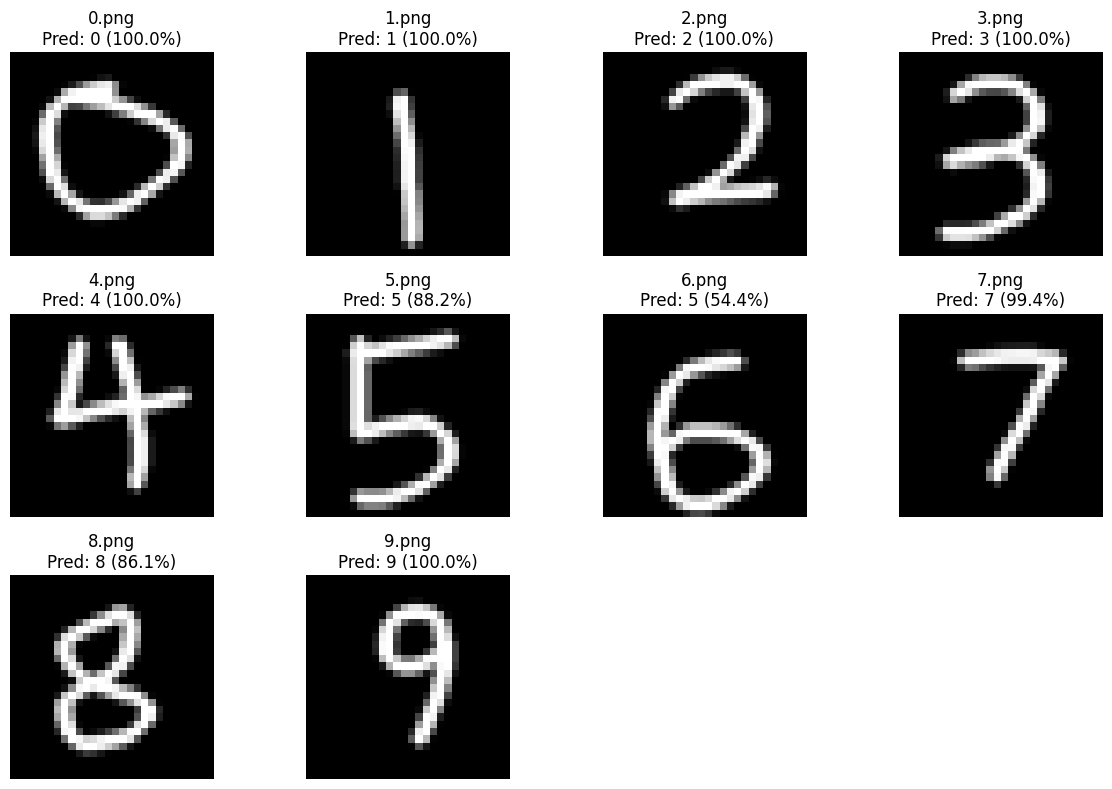

In [ ]:
# RUN TIME: 0.6s

input_size = 28 * 28
hidden1_size = 512
hidden2_size = 256
hidden3_size = 128
hidden4_size = 64
output_size = 10

with h5py.File("trained_model_2.h5", "r") as hf:
    loaded_model = NeuralNetwork(
        input_layer = 28*28,
        hidden1 = 512, hidden2 = 256, hidden3 = 128, hidden4 = 64,
        output_layer = 10
    )

    loaded_model.weight1 = hf["weight1"][:]
    loaded_model.bias1 = hf["bias1"][:]
    loaded_model.weight2 = hf["weight2"][:]
    loaded_model.bias2 = hf["bias2"][:]
    loaded_model.weight3 = hf["weight3"][:]
    loaded_model.bias3 = hf["bias3"][:]
    loaded_model.weight4 = hf["weight4"][:]
    loaded_model.bias4 = hf["bias4"][:]
    loaded_model.weight5 = hf["weight5"][:]
    loaded_model.bias5 = hf["bias5"][:]

def thicken(arr, passes):
    for _ in range(passes):
        up    = np.zeros_like(arr); up[:-1, :] = arr[1:, :]
        down  = np.zeros_like(arr); down[1:, :] = arr[:-1, :]
        left  = np.zeros_like(arr); left[:, :-1] = arr[:, 1:]
        right = np.zeros_like(arr); right[:, 1:] = arr[:, :-1]
        arr = np.maximum.reduce([arr, up, down, left, right])
    return arr

test_directory_name = "../my_images"
all_files = os.listdir(test_directory_name)
selected_images = all_files
parsed_image_list = []
flattened_images = []

for fname in selected_images:
    path = os.path.join(test_directory_name, fname)
    try:
        img = Image.open(path)
        img = img.convert('L')

        # before we resize, let's invert the image
        arr = np.array(img, dtype=np.float32)
        arr = 255 - arr
        arr = thicken(arr, 11)
        
        img = Image.fromarray(arr.astype(np.uint8))
        img = img.resize((28, 28))
        parsed_image_list.append(img)

        arr = np.asarray(img, dtype=np.float32).flatten() / 255.0
        flattened_images.append(arr)

    except Exception as e:
        print(f"ERROR loading {fname}: {e}")

flattened_test = np.stack(flattened_images)
probs = loaded_model.forward_propagation(flattened_test)
predictions = np.argmax(probs, axis=1)
confidence  = np.max(probs, axis=1) * 100
plt.figure(figsize=(12, 8))

for i, (img, pred, conf, fname) in enumerate(zip(parsed_image_list, predictions, confidence, selected_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{fname}\nPred: {pred} ({conf:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# at this point, we should see higher confidency overall
# you might see the AI predicting some digits inaccurately
# but, that's totally fine as long as the confidency is low (below 60% expected)